# Gray Scale Model

### Important Variables:

In this task we will be implementing the SIR model with the following system parameters:

*   $a_{i}(b)$: total amount of assets hold by user i by the end of block b.
*   $d_{i}(b)$: total amount of black assets hold by node i by the end of block b.
*   $x_{i}(b)$: = $\frac{d_{i}(b)}{a_{i}(b)} $ black assets fraction by the end of block b.
*   $c_{i}(b)$: amount of clean asset owned by node i by the end of block b
*   $m_{i}(b)$: the amount mined by user i by the end of block b
*   $W(b)$: = {$w_{ij}$}$_{i,j=1,...,N}$ is the adjacency matrix of the transaction network at block b. wij is equal to the amount of bitcoin moved from user i to user j at block b.
*   $N = Nusers = |Nusers|$ total number of users in the network.

Below is a summary of the dynamics of the SIR model:

In [2]:
import blocksci

import sys, os, os.path, socket
import numpy as np
import zarr
import time
import pandas as pd
from collections import defaultdict
from decimal import Decimal
import math
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import networkx as nx
import graph_tool.all as gt
import seaborn as sns
from scipy.stats.kde import gaussian_kde
from numpy import linspace


from util import SYMBOLS, DIR_BCHAIN, DIR_PARSED, SimpleChrono, darknet

def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

def daterange(date1, date2, by=1):
    return [  date1 + timedelta(n) for n in range(0, int((date2 - date1).days)+1, by) ]     

/tmp/ipykernel_2784624/786907412.py:19: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


# Address Mapper Class

In [ ]:
# this class creates a map from addresses to the set {0 -> number of cluster}, in other words it helps to use arrays to store the information. 
class AddressMapper(): # This creates the map that clusters the addresses to actual users. Treat it a a blackbox for now.
    def __init__(self, chain):
        self.chain = chain

        self.__address_types = [blocksci.address_type.nonstandard, blocksci.address_type.pubkey,
                                blocksci.address_type.pubkeyhash, blocksci.address_type.multisig_pubkey,
                                blocksci.address_type.scripthash, blocksci.address_type.multisig,
                                blocksci.address_type.nulldata, blocksci.address_type.witness_pubkeyhash,
                                blocksci.address_type.witness_scripthash, blocksci.address_type.witness_unknown]

        self.__counter_addresses = { _:self.chain.address_count(_) for _ in self.__address_types }

        self.__offsets = {}
        offset = 0
        for _ in self.__address_types:
            self.__offsets[_] = offset
            offset += self.__counter_addresses[_]


        self.total_addresses = offset
        print(f"[INFO] #addresses: {self.total_addresses}")
#        print(self.__counter_addresses)


    def map_clusters(self,cm):
#        address_vector = {_: np.zeros(self.__counter_addresses[_], dtype=np.int64) for _ in self.__address_types }
        cluster_vector = {_: np.zeros(self.__counter_addresses[_], dtype=np.int64) for _ in self.__address_types }

        self.cluster = np.zeros(self.total_addresses, dtype=np.int64)
        offset = 0
        for _at in cluster_vector.keys():
            clusters = cluster_vector[_at]
            print(f"{_at}     -  {len(clusters)}")
#            addrs = address_vector[_at]
            for _i, _add in enumerate(chain.addresses(_at)):
#                addrs[_i] = _add.address_num
                clusters[_i] = cm.cluster_with_address(_add).index
                #max_addr_num = max(max_addr_num, addrs[_i])
#        pickle.dump(cluster_vector, open("cluster_dict.pickle","wb"))

        offset = 0
        for _ in cluster_vector.keys():
            v = cluster_vector[_]
            self.cluster[offset:offset + len(v)] = v
            offset += len(v)



    def dump_clusters(self, output_folder):
        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        zarr.save(f"{output_folder}/address_cluster_map.zarr", self.cluster)


#    def dump_offsets(self, output_folder):
#        if not os.path.exists(output_folder):
#            os.mkdir(output_folder)
#        pickle.dump(self.__offsets, open(f"{output_folder}/offsets.pickle", "wb") )

#    def load_offsets(self, output_folder):
#        if not os.path.exists(output_folder):
#            os.mkdir(output_folder)
#        self.__offsets = pickle.load( open(f"{output_folder}/offsets.pickle", "rb") )

    def load_clusters(self, input_folder):
        print(f"{input_folder}address_cluster_map.zarr")
        self.cluster = zarr.load(f"{input_folder}address_cluster_map.zarr")



    def __getitem__(self,addr):
        return self.__offsets[addr.raw_type]+ addr.address_num-1

def catch(address, am):
    try:
        return am[address] 
    except:
        return np.nan

# Total Bitcoin Vs. Total Dark Bitcoin for H1 and H2:

No handles with labels found to put in legend.
/tmp/ipykernel_3289340/2817820160.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, y_values, 'k-', color='b', linewidth=3, label="Total Circulating BTC")
/tmp/ipykernel_3289340/2817820160.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates_bcdotcom, y_values_BCDOTCOM, 'k-', color='g', linewidth=3, label="Total Circulating BTC - Blockchain.com")
/tmp/ipykernel_3289340/2817820160.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, y_values_DA, 'kx', color='black', linewidth=3, label="Total Circulating Dark BTC - H1")
/tmp/ipykernel_3289340/28

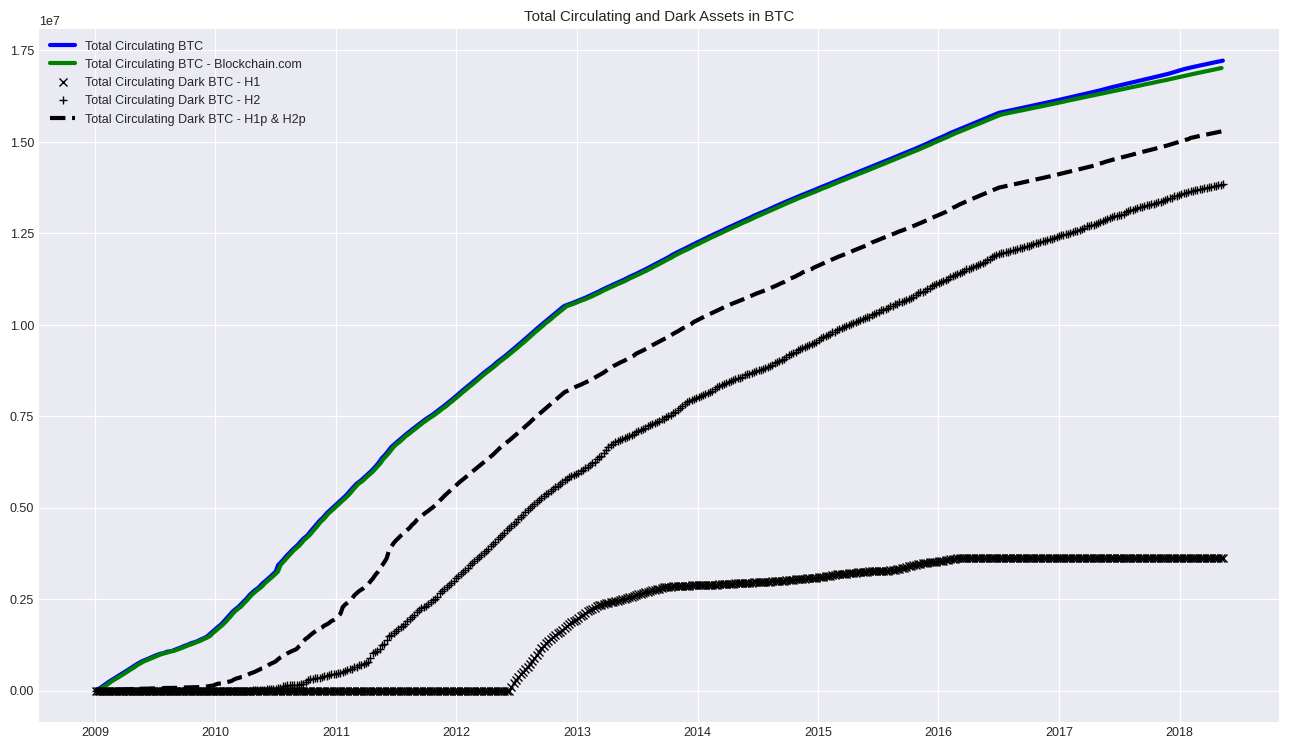

In [40]:
# Saving plotted figures/images
# Plotting CA and DA on same figure
start_date = datetime.strptime("2009-01-03", "%Y-%m-%d").date()
end_date = datetime.strptime("2018-05-12", "%Y-%m-%d").date()
x_values = []
x_values_bcdotcom = []
y_values = []
y_values_DA = []
y_values_DA_h2 = []
y_values_DA_h1p = []
y_values_DA_h2p = []
y_values_BCDOTCOM = []

with open(f'jsonResults_v3/h1/Total_CA_{start_date}_{end_date}.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        x_values.append(iterator)
        y_values.append(float(load_json[iterator]))

with open(f'jsonResults_v3/h1/Total_DA_{start_date}_{end_date}.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        y_values_DA.append(float(load_json[iterator]))

with open(f'jsonResults_v3/h2/Total_DA_{start_date}_{end_date}.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        y_values_DA_h2.append(float(load_json[iterator]))

with open(f'jsonResults_v3/h1p/Total_DA_{start_date}_{end_date}.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        y_values_DA_h1p.append(float(load_json[iterator]))

with open(f'jsonResults_v3/h2p/Total_DA_{start_date}_{end_date}.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        y_values_DA_h2p.append(float(load_json[iterator]))

with open(f'jsonResults_v3/Total_CA_BCDOTCOM_converted_2009-01-03_2018-05-12.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        x_values_bcdotcom.append(iterator)
        y_values_BCDOTCOM.append(float(load_json[iterator]))

dates_bcdotcom = mdates.date2num(x_values_bcdotcom)
dates = mdates.date2num(x_values)
fig = plt.figure(figsize=(16, 9), dpi=100)
plt.style.use('seaborn-darkgrid')
plt.legend(loc="upper left")
plt.plot_date(dates, y_values, 'k-', color='b', linewidth=3, label="Total Circulating BTC")
plt.plot_date(dates_bcdotcom, y_values_BCDOTCOM, 'k-', color='g', linewidth=3, label="Total Circulating BTC - Blockchain.com")
plt.plot_date(dates, y_values_DA, 'kx', color='black', linewidth=3, label="Total Circulating Dark BTC - H1")
plt.plot_date(dates, y_values_DA_h2, 'k+', color='black', linewidth=3, label="Total Circulating Dark BTC - H2")
plt.plot_date(dates, y_values_DA_h1p, 'k--', color='black', linewidth=3, label="Total Circulating Dark BTC - H1p & H2p")
plt.legend()
plt.gca().set_title("Total Circulating and Dark Assets in BTC")

plt.savefig(f'finalPlots/TotalAssets_plot.png', dpi=100)


In [19]:
import json
from datetime import datetime, timedelta

def convert_format(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        data = json.load(file)
    
    bitcoin_data = data["total-bitcoins"]
    
    start_date = datetime.strptime("2009-01-10", "%Y-%m-%d").date()
    end_date = datetime.strptime("2018-05-12", "%Y-%m-%d").date()

    formatted_data = {}
    for entry in bitcoin_data:
        # Convert the timestamp to a date string
        current_date = datetime.utcfromtimestamp(entry["x"] / 1000).date()
        
        # Filter dates outside the range
        if start_date <= current_date <= end_date:
            date_str = current_date.strftime('%Y-%m-%d')
            formatted_data[date_str] = float(entry["y"])
            
            # Skip the next 6 days to achieve a 7-day interval
            start_date = current_date + timedelta(days=7)

    # Save the formatted data to a new JSON file
    with open(output_file_path, 'w') as file:
        json.dump(formatted_data, file, indent=4)

# Specify the paths
input_path = "jsonResults_v3/Total_CA_BCDOTCOM_2009-01-03_2018-05-12.json"
output_path = "jsonResults_v3/Total_CA_BCDOTCOM_converted_2009-01-03_2018-05-12.json"

# Convert and save
convert_format(input_path, output_path)


# Percentage of Clusters per Dark Ratio Interval for H1 and H2:

/tmp/ipykernel_3289340/3529905848.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot_date(x_values, y_values, 'k-', color=color, linewidth=4, label=label)


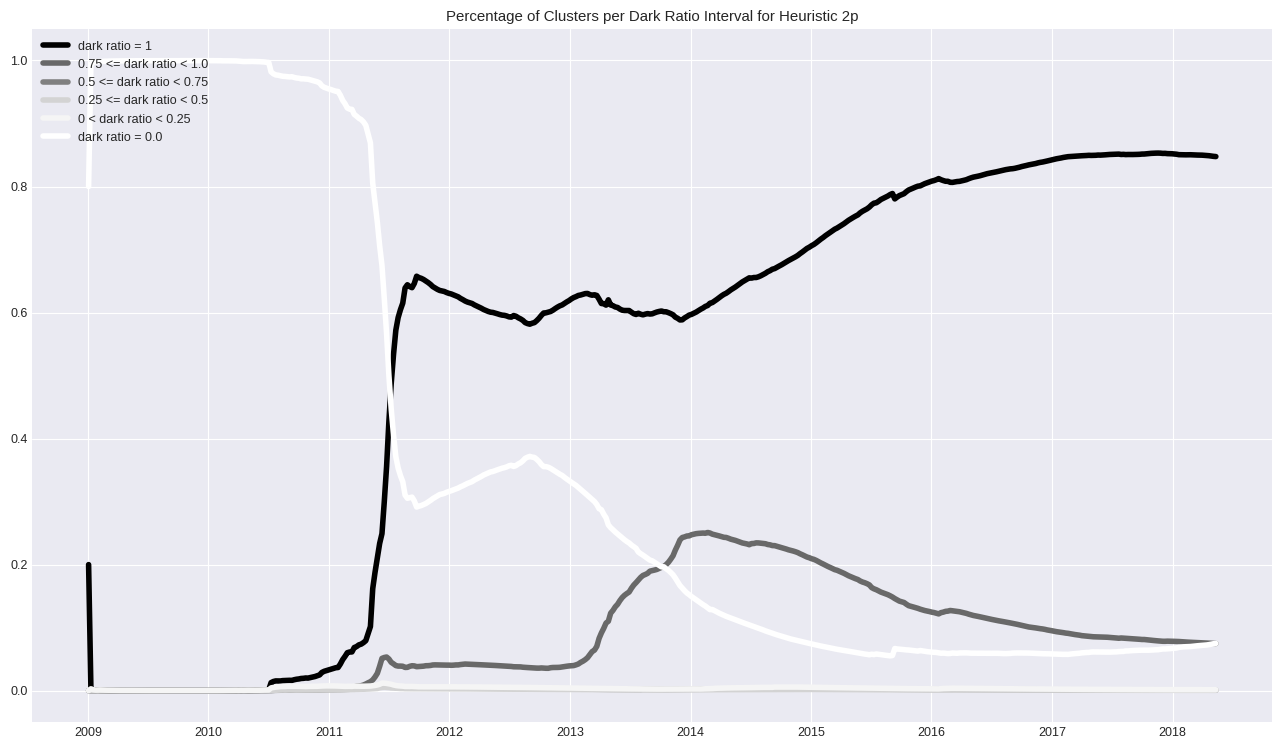

In [42]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

heuristic = "2p"  # ensure this variable is defined
start_date = datetime.strptime("2009-01-03", "%Y-%m-%d").date()
end_date = datetime.strptime("2018-05-12", "%Y-%m-%d").date()

# Define the paths of your JSON files
file_paths = [
    f'jsonResults_v3/h{heuristic}/DR_black_2009-01-03_{end_date}.json',
    f'jsonResults_v3/h{heuristic}/DR_dark_grey_2009-01-03_{end_date}.json',
    f'jsonResults_v3/h{heuristic}/DR_grey_2009-01-03_{end_date}.json',
    f'jsonResults_v3/h{heuristic}/DR_light_grey_2009-01-03_{end_date}.json',
    f'jsonResults_v3/h{heuristic}/DR_greyish_white_2009-01-03_{end_date}.json',
    f'jsonResults_v3/h{heuristic}/DR_white_2009-01-03_{end_date}.json',
]

colors = ['black', 'dimgray', 'gray', 'lightgray', 'whitesmoke', 'white']
labels = ["dark ratio = 1", "0.75 <= dark ratio < 1.0", "0.5 <= dark ratio < 0.75", "0.25 <= dark ratio < 0.5", "0 < dark ratio < 0.25", "dark ratio = 0.0"]

# Start plotting
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(f"Percentage of Clusters per Dark Ratio Interval for Heuristic {heuristic}")

# For each file path
for file_path, color, label in zip(file_paths, colors, labels):
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    # We assume the data is a dict with date strings as keys
    x_values = [mdates.datestr2num(date) for date in data.keys()]  # convert date strings to matplotlib date format
    y_values = [v for v in data.values()]
        
    ax.plot_date(x_values, y_values, 'k-', color=color, linewidth=4, label=label)

plt.style.use('seaborn-darkgrid')
plt.legend(loc="upper left")
plt.savefig(f'finalPlots/DarkRatioDistribution_H{heuristic}.png', dpi=100)

/tmp/ipykernel_3289340/1992575126.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot_date(x_values, y_values, 'k-', color=color, linewidth=2, label=label)


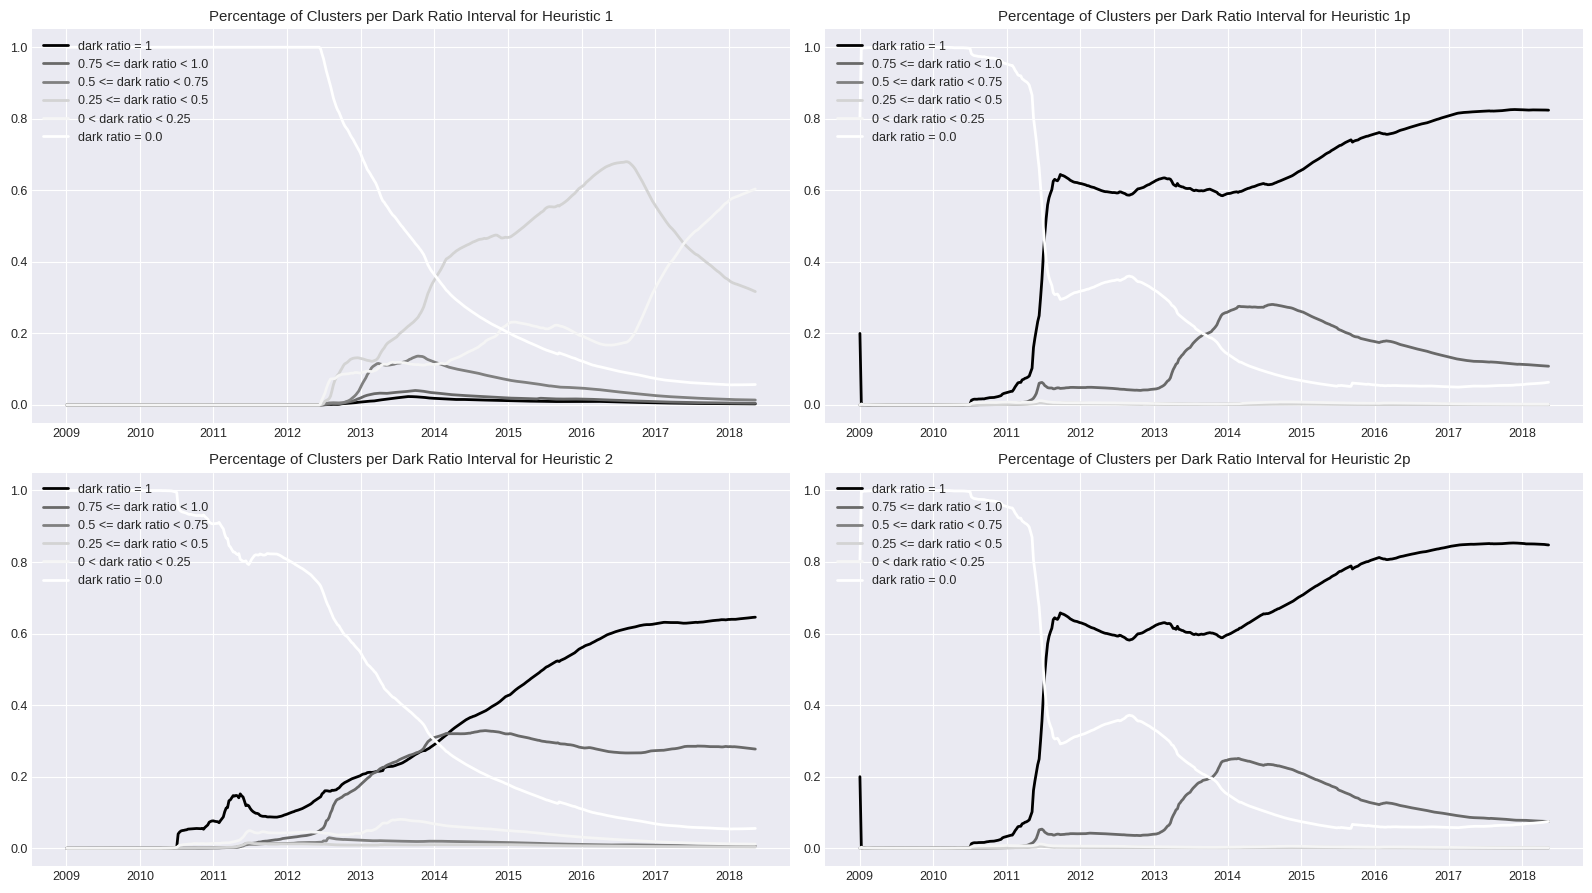

In [43]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Ensure start_date and end_date are defined
start_date = datetime.strptime("2009-01-03", "%Y-%m-%d").date()
end_date = datetime.strptime("2018-05-12", "%Y-%m-%d").date()

heuristics = ["1", "1p", "2", "2p"]  # List of heuristics

# Define the paths of your JSON files
base_file_paths = [
    'DR_black_2009-01-03_{}.json',
    'DR_dark_grey_2009-01-03_{}.json',
    'DR_grey_2009-01-03_{}.json',
    'DR_light_grey_2009-01-03_{}.json',
    'DR_greyish_white_2009-01-03_{}.json',
    'DR_white_2009-01-03_{}.json',
]

colors = ['black', 'dimgray', 'gray', 'lightgray', 'whitesmoke', 'white']
labels = ["dark ratio = 1", "0.75 <= dark ratio < 1.0", "0.5 <= dark ratio < 0.75", "0.25 <= dark ratio < 0.5", "0 < dark ratio < 0.25", "dark ratio = 0.0"]

# Start plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 9))

for ax, heuristic in zip(axes.flatten(), heuristics):
    file_paths = [f'jsonResults_v3/h{heuristic}/{base_path.format(end_date)}' for base_path in base_file_paths]
    ax.set_title(f"Percentage of Clusters per Dark Ratio Interval for Heuristic {heuristic}")

    for file_path, color, label in zip(file_paths, colors, labels):
        with open(file_path, 'r') as f:
            data = json.load(f)

        # We assume the data is a dict with date strings as keys
        x_values = [mdates.datestr2num(date) for date in data.keys()]  # convert date strings to matplotlib date format
        y_values = [v for v in data.values()]
            
        ax.plot_date(x_values, y_values, 'k-', color=color, linewidth=2, label=label)
    ax.legend(loc="upper left")

plt.style.use('seaborn-darkgrid')
plt.tight_layout()
# plt.savefig('finalPlots/DarkRatioDistribution_Grid.png', dpi=100)


# DA, CA, DR (4 plots?) probability density functions / distributions

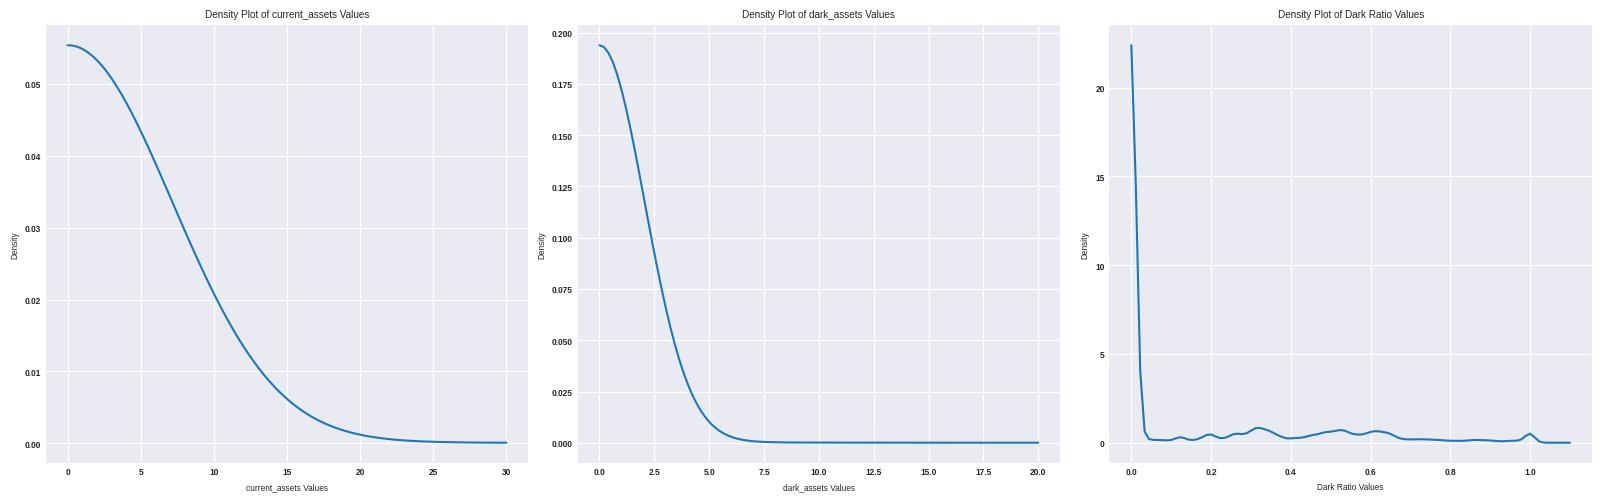

In [38]:
# Plots in BTC 

fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=100)

date = "2013-03-19"

# First subplot: Density Plot of current_assets Values
dark_ratio_zarr = zarr.load(f'/srv/abacus-1/bitcoin_darknet/grayscale_op_ali/heur_1_data_v3/daily/current_assets/current_assets_{date}.zarr')
dark_ratio_zarr = dict(zip(dark_ratio_zarr["current_assets_index"], dark_ratio_zarr["current_assets_values"]))

values = list(dark_ratio_zarr.values())
values = np.array(values)
data = values / 1e8

kde = gaussian_kde(data)
dist_space = linspace(min(data), 30, 100)

axes[0].plot(dist_space, kde(dist_space))
axes[0].set_title('Density Plot of current_assets Values')
axes[0].set_xlabel('current_assets Values')
axes[0].set_ylabel('Density')

# Second subplot: Density Plot of dark_assets Values
dark_ratio_zarr = zarr.load(f'/srv/abacus-1/bitcoin_darknet/grayscale_op_ali/heur_1_data_v3/daily/dark_assets/dark_assets_{date}.zarr')
dark_ratio_zarr = dict(zip(dark_ratio_zarr["dark_assets_index"], dark_ratio_zarr["dark_assets_values"]))

values = list(dark_ratio_zarr.values())
values = np.array(values)
values = values.astype(float)
data = values / 1e8

kde = gaussian_kde(data)
dist_space = linspace(min(data), 20, 100)

axes[1].plot(dist_space, kde(dist_space))
axes[1].set_title('Density Plot of dark_assets Values')
axes[1].set_xlabel('dark_assets Values')
axes[1].set_ylabel('Density')

# Third subplot: Density Plot of Dark Ratio Values
dark_ratio_zarr = zarr.load(f'/srv/abacus-1/bitcoin_darknet/grayscale_op_ali/heur_1_data_v3/daily/dark_ratio/dark_ratio_{date}.zarr')
dark_ratio_zarr = dict(zip(dark_ratio_zarr["dark_ratio_index"], dark_ratio_zarr["dark_ratio_values"]))

values = list(dark_ratio_zarr.values())
values = np.array(values)
data = values.astype(float)

kde = gaussian_kde(data)
dist_space = linspace(min(data), 1.1, 100)

axes[2].plot(dist_space, kde(dist_space))
axes[2].set_title('Density Plot of Dark Ratio Values')
axes[2].set_xlabel('Dark Ratio Values')
axes[2].set_ylabel('Density')

plt.tight_layout()
plt.show()

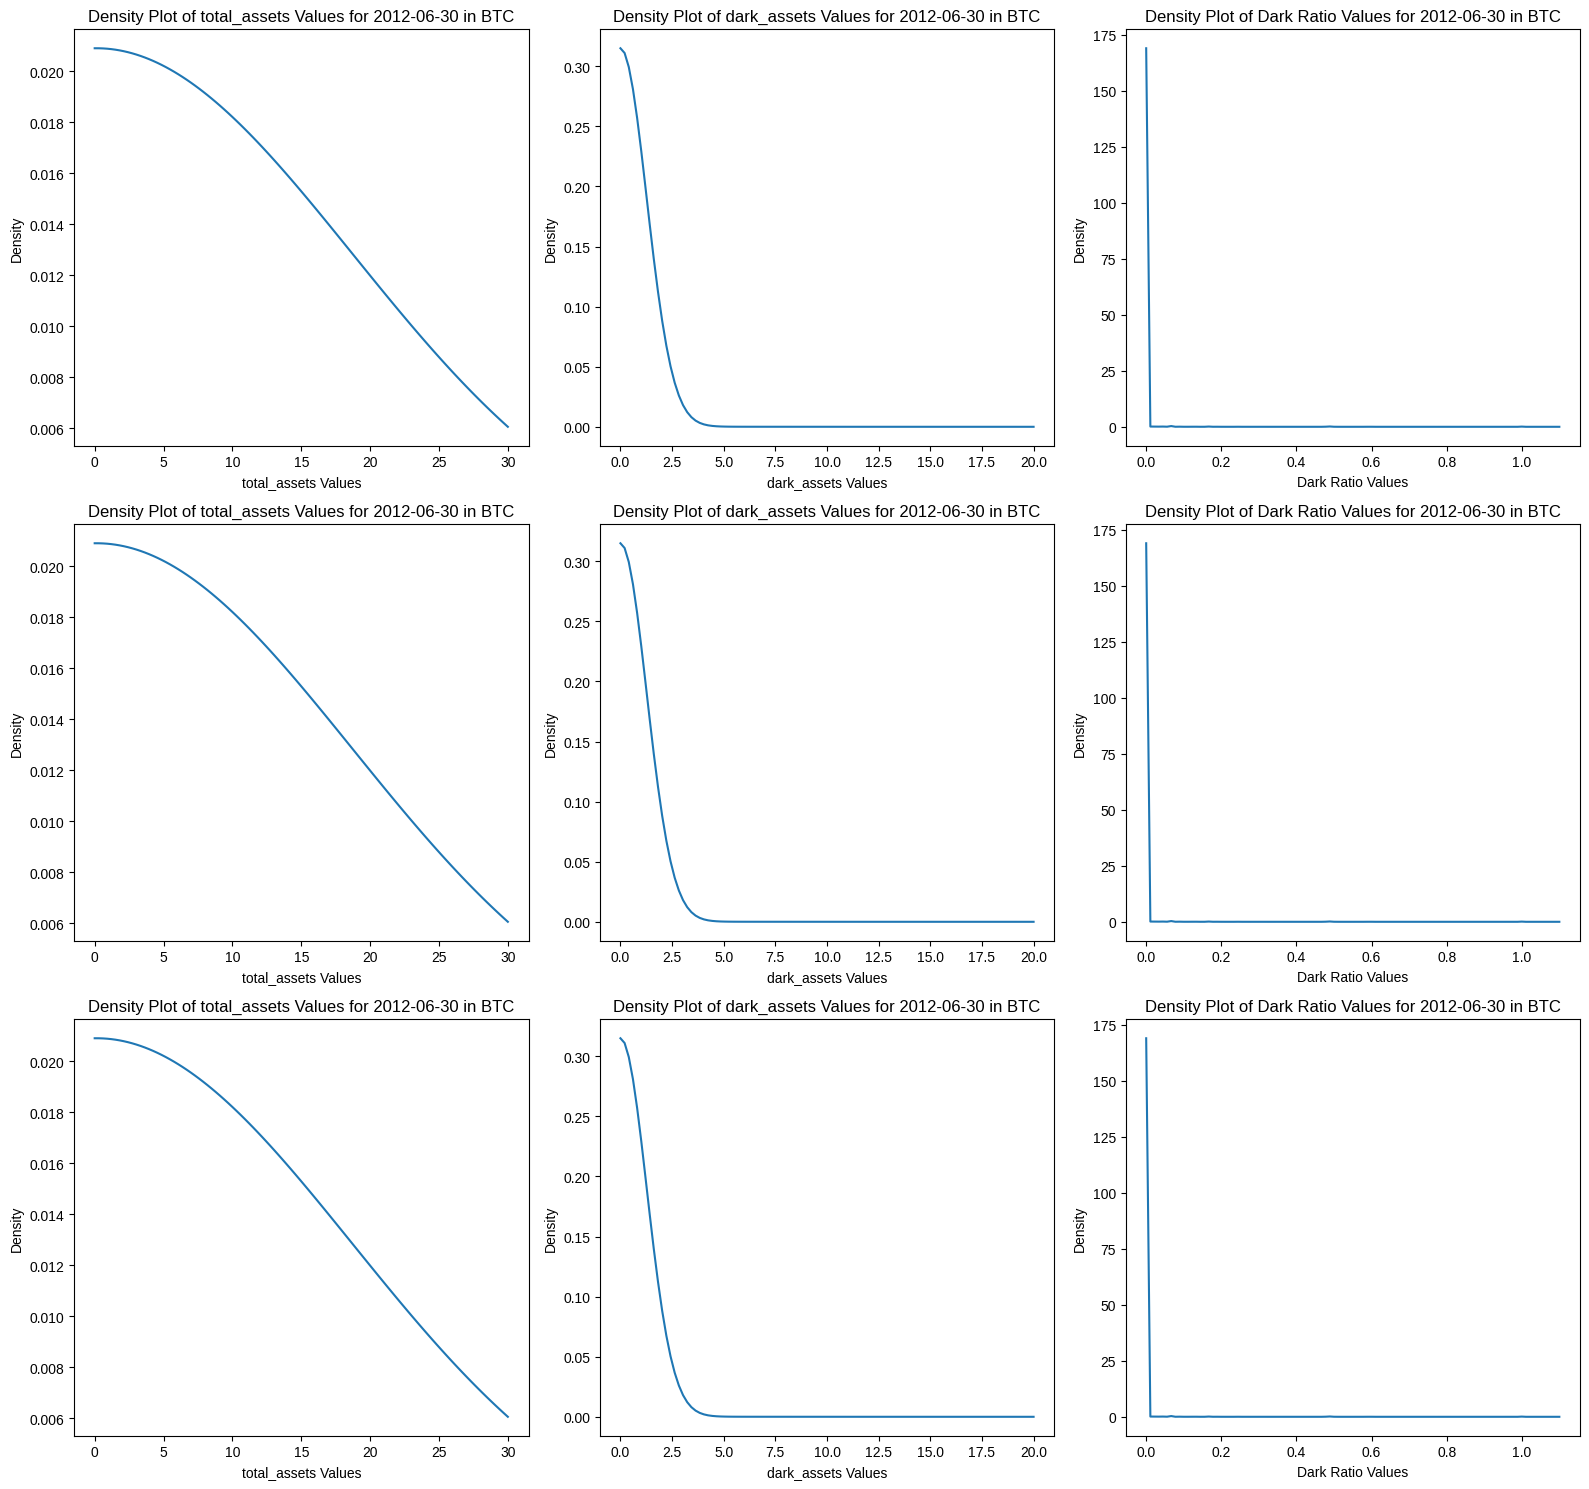

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import linspace

def plot_density(data, ax, title, xlabel, ylabel, max_xlim):
    kde = gaussian_kde(data)
    dist_space = linspace(min(data), max_xlim, 100)
    ax.plot(dist_space, kde(dist_space))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

dates = ["2012-06-30", "2012-06-30", "2012-06-30"]

# 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(16, 15), dpi=100)

for i, date in enumerate(dates):
    # For current_assets
    zarr_data = zarr.load(f'/srv/abacus-1/bitcoin_darknet/grayscale_op_ali/heur_1_data_v3/daily/current_assets/current_assets_{date}.zarr')
    current_assets_dict = dict(zip(zarr_data["current_assets_index"], zarr_data["current_assets_values"]))
    data = np.array([value for value in current_assets_dict.values()]) / 1e8
    plot_density(data, axes[i, 0], f'Density Plot of total_assets Values for {date} in BTC', 'total_assets Values', 'Density', 30)

    # For dark_assets
    zarr_data = zarr.load(f'/srv/abacus-1/bitcoin_darknet/grayscale_op_ali/heur_1_data_v3/daily/dark_assets/dark_assets_{date}.zarr')
    dark_assets_dict = dict(zip(zarr_data["dark_assets_index"], zarr_data["dark_assets_values"]))
    data = np.array([value for value in dark_assets_dict.values()]) / 1e8
    plot_density(data, axes[i, 1], f'Density Plot of dark_assets Values for {date} in BTC', 'dark_assets Values', 'Density', 20)

    # For dark_ratio
    zarr_data = zarr.load(f'/srv/abacus-1/bitcoin_darknet/grayscale_op_ali/heur_1_data_v3/daily/dark_ratio/dark_ratio_{date}.zarr')
    dark_ratio_dict = dict(zip(zarr_data["dark_ratio_index"], zarr_data["dark_ratio_values"]))
    data = np.array([value for value in dark_ratio_dict.values()])
    plot_density(data, axes[i, 2], f'Density Plot of Dark Ratio Values for {date} in BTC', 'Dark Ratio Values', 'Density', 1.1)

plt.style.use('seaborn-darkgrid')
plt.tight_layout()
plt.savefig('finalPlots/AttributeDistributions_3x3Grid.png', dpi=100)
plt.show()


# DNM Activity and Total Assets + validation data

[INF] Below is the ground_truth_clust_id dark entities for heuristic 1...
entity
AbraxasMarket                                                   [101080866]
AlphaBayMarket                                       [107302595, 115726064]
BabylonMarket                                                    [94998167]
BlackBankMarket                                                  [90613521]
BlueSkyMarketplace                                               [88316586]
CannabisRoadMarket                                               [92044383]
EvolutionMarket           [89576173, 99061401, 99061408, 99064866, 99066...
GreenRoadMarket                                                 [112150330]
MiddleEarthMarketplace                                           [94494584]
NucleusMarket                                                    [99422262]
PandoraOpenMarket                                                [86826333]
SheepMarketplace                                                 [82285475]
SilkRoa

/tmp/ipykernel_3289340/3051281234.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, wallet_explorer, 'k-', color='green', label=f"WalletExplorer")
/tmp/ipykernel_3289340/3051281234.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, wallet_explorer, 'k-', color='green', label=f"WalletExplorer")
/tmp/ipykernel_3289340/3051281234.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, wallet_explorer, 'k-', color='green', label=f"WalletExplorer")
/tmp/ipykernel_3289340/3051281234.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color

AttributeError: 'numpy.ndarray' object has no attribute 'get_legend_handles_labels'

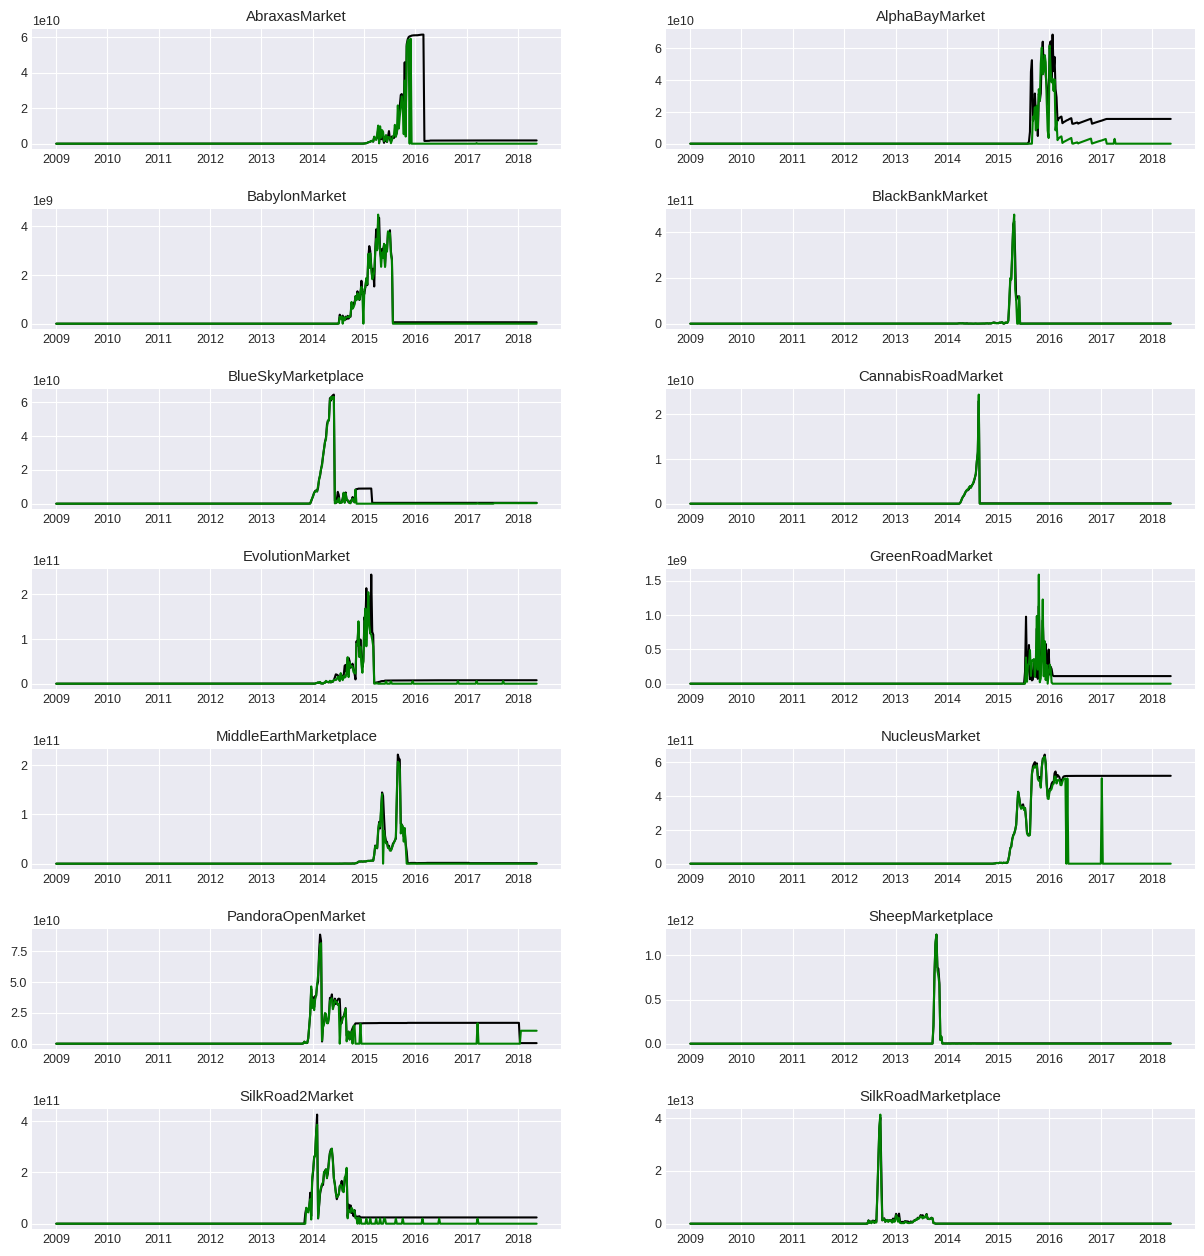

In [46]:
# Plots in Satoshis 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta
import json

heuristic = "1"  # ensure this variable is defined
start_date = datetime.strptime("2009-01-03", "%Y-%m-%d").date()
end_date = datetime.strptime("2018-05-12", "%Y-%m-%d").date()

print(f"[INF] Below is the ground_truth_clust_id dark entities for heuristic {heuristic}...")
df = pd.read_csv(f"uniform_black/heur_{heuristic}_data/ground_truth_clust_id.csv")
cluster_table = df.groupby(['entity'])["cluster_id"].unique()
print(cluster_table)

# Plotting DNMs on same figure
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15, 15))
fig.tight_layout()
plot_number = 1

for dnm, list in cluster_table.items():
    x_values = []
    y_values = []
    with open(f'jsonResults_v3/h{heuristic}/total_assets_{dnm}_{start_date}_{end_date}.json', 'r') as f:
        load_json = json.load(f)
        for iterator in load_json:
            x_values.append(iterator)
            y_values.append(float(load_json[iterator]))
        
    dates = mdates.datestr2num(x_values)
    plt.subplot(7, 2, plot_number)
    plt.gca().set_title(f'{dnm}')
    plt.plot_date(dates, y_values, 'k-', label=f"Grayscale diffusion")
    
    # Load and plot wallet_explorer data if it exists
    try:
        with open(f'walletexplorer_DNM/{dnm}.json', 'r') as f:
            load_json = json.load(f)
            wallet_explorer = [float(load_json[date]) * 100000000 for date in x_values]
            plt.plot_date(dates, wallet_explorer, 'k-', color='green', label=f"WalletExplorer")
    except FileNotFoundError:
        print(f"No walletexplorer_DNM data found for {dnm}")
    
    plot_number += 1

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.style.use('seaborn-darkgrid')
plt.legend(loc="upper left")
fig.savefig(f'finalPlots/DNMsPlot_H{heuristic}.png', dpi=100)


# Stat Calculator

In [6]:
import json
import numpy as np
from scipy import stats

# Function to load data from a JSON file
def load_data(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

# Function to summarize data
def summarize_data(data):
    values = np.array(list(data.values()))

    # Remove NaN values
    values = values[~np.isnan(values)]
    
    mean_value = np.mean(values)
    median_value = np.median(values)
    std_value = np.std(values)
    min_value = np.min(values)
    max_value = np.max(values)
    skewness = stats.skew(values)
    kurtosis = stats.kurtosis(values)
    
    return {
        "Mean": mean_value,
        "Median": median_value,
        "Std Dev": std_value,
        "Min": min_value,
        "Max": max_value,
        "Skewness": skewness,
        "Kurtosis": kurtosis
    }

# Assortative Mixing in User Transaction Networks H1 and H2 (though h2 might not make sense)

No handles with labels found to put in legend.
/tmp/ipykernel_2026655/1500986353.py:78: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates_real_DR, list(data["real_DR"].values()), 'k.', linewidth=2, color='#008176', label="real_DR_modularity")
/tmp/ipykernel_2026655/1500986353.py:79: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates_h1, y_values_assortativity_h1, 'k-', color='#eecc16', linewidth=3, label="Heuristic 1 Weekly UTN")
/tmp/ipykernel_2026655/1500986353.py:80: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates_h2, y_values_assortativity_h2, 'k+', color='blue', linewidth=3, label="Heuristic 2 Weekly

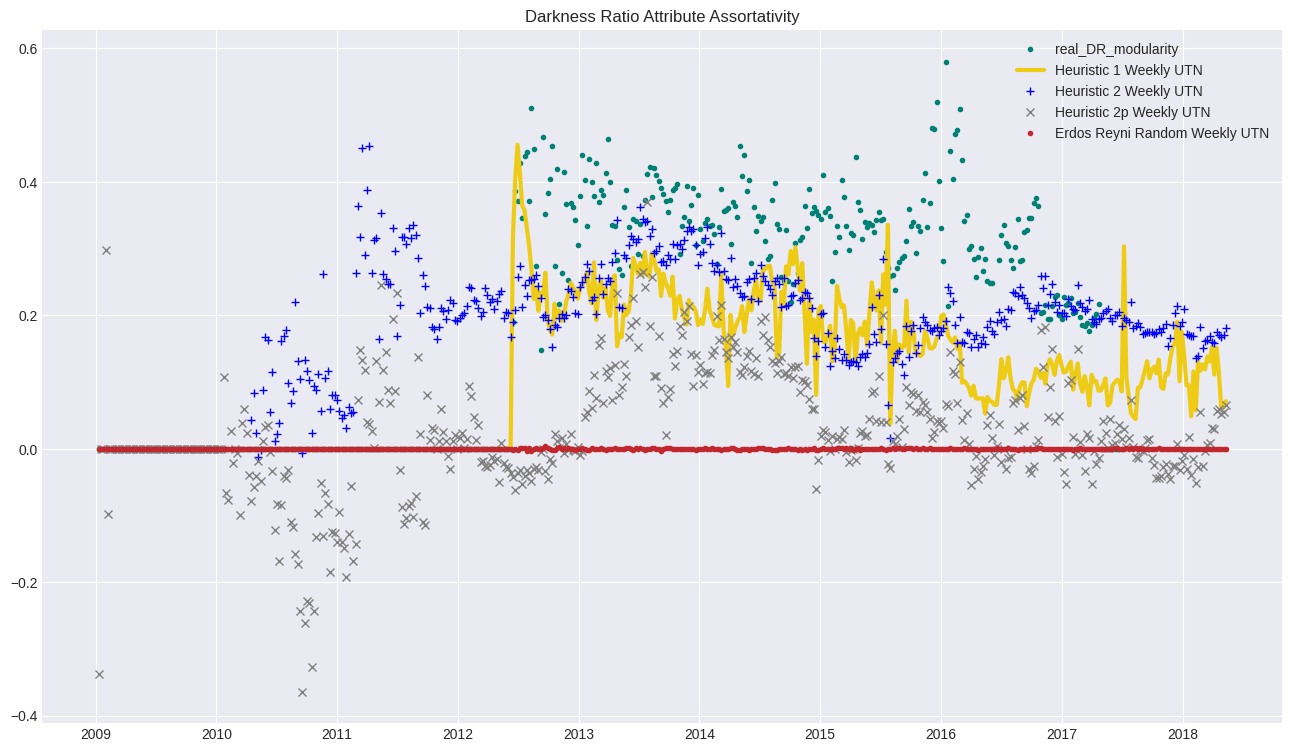

In [39]:
# Plots in Satoshis 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta
import json

heuristic = 1  # ensure this variable is defined
start_date = datetime.strptime("2009-01-03", "%Y-%m-%d").date()
end_date = datetime.strptime("2018-05-12", "%Y-%m-%d").date()

x_values_h1 = []
x_values_h2 = []
x_values_h2p = []
x_values_random = []
y_values_assortativity_h1 = []
y_values_assortativity_h2 = []
y_values_assortativity_h2p = []
y_values_assortativity_random = []

with open(f'jsonResults_v3/h1/NEW_assortativity_2009-01-03_{end_date}.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        x_values_h1.append(iterator)
        y_values_assortativity_h1.append(float(load_json[iterator]))

with open(f'jsonResults_v3/h2/NEW_assortativity_2009-01-03_{end_date}.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        x_values_h2.append(iterator)
        y_values_assortativity_h2.append(float(load_json[iterator]))

with open(f'jsonResults_v3/h2p/NEW_assortativity_2009-01-03_{end_date}.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        x_values_h2p.append(iterator)
        y_values_assortativity_h2p.append(float(load_json[iterator]))

with open(f'jsonResults_v3/h{heuristic}/random/directed_random_assortativity_2009-01-03_{end_date}.json', 'r') as f:
    load_json = json.load(f)
    for iterator in load_json:
        x_values_random.append(iterator)
        y_values_assortativity_random.append(float(load_json[iterator]))


# Load the additional modularity data
data_dicts = {
    'real_DR': {},
    'real_SBM': {},
    'random_DR': {},
    'random_SBM': {},
    'maximum_modularity': {},
    'clustering': {},
    'clustering_std': {}
}

data = {}
for key in data_dicts.keys():
    file_path = os.path.join(f'jsonResults_v3/h1/community', f'real_DR_2009-01-03_2017-07-08.json')
    with open(file_path, 'r') as f:
        data[key] = json.load(f)

# Prepare dates for the new data
dates_real_DR = mdates.date2num(list(data["real_DR"].keys()))



#

dates_h1 = mdates.date2num(x_values_h1)
dates_h2 = mdates.date2num(x_values_h2)
dates_h2p = mdates.date2num(x_values_h2p)
dates_random = mdates.date2num(x_values_random)
fig = plt.figure(figsize=(16, 9), dpi=100)
plt.style.use('seaborn-darkgrid')
plt.legend(loc="upper left")
plt.plot_date(dates_real_DR, list(data["real_DR"].values()), 'k.', linewidth=2, color='#008176', label="real_DR_modularity")
plt.plot_date(dates_h1, y_values_assortativity_h1, 'k-', color='#eecc16', linewidth=3, label="Heuristic 1 Weekly UTN")
plt.plot_date(dates_h2, y_values_assortativity_h2, 'k+', color='blue', linewidth=3, label="Heuristic 2 Weekly UTN")
plt.plot_date(dates_h2p, y_values_assortativity_h2p, 'kx', color='gray', linewidth=3, label="Heuristic 2p Weekly UTN")
plt.plot_date(dates_random, y_values_assortativity_random, 'k.', color='#c1272d', linewidth=3, label="Erdos Reyni Random Weekly UTN")
plt.legend()
plt.gca().set_title("Darkness Ratio Attribute Assortativity")
plt.savefig(f'finalPlots/NEW_AssortativityPlot_H{heuristic}.png', dpi=100)


In [34]:
# Your specific end_date and heuristic variables
end_date = "2018-05-12"  # Example end date, replace with your actual end date

# List of your data file names
filenames = [
    f'jsonResults_v3/h1/NEW_assortativity_2009-01-03_{end_date}.json',
    f'jsonResults_v3/h2/NEW_assortativity_2009-01-03_{end_date}.json',
    f'jsonResults_v3/h2p/NEW_assortativity_2009-01-03_{end_date}.json',
    f'jsonResults_v3/h1/random/directed_random_assortativity_2009-01-03_{end_date}.json'
]

# Loop over each file to load and summarize the data
for filename in filenames:
    data = load_data(filename)
    summary = summarize_data(data)
    print(f"Summary for {filename}:")
    for key, value in summary.items():
        print(f"{key}: {value}")
    print()

Summary for jsonResults_v3/h1/NEW_assortativity_2009-01-03_2018-05-12.json:
Mean: 0.16983891213257188
Median: 0.16957256104117538
Std Dev: 0.07601847562094859
Min: 0.0
Max: 0.455606852031582
Skewness: 0.319579953996105
Kurtosis: 0.24936377786075736

Summary for jsonResults_v3/h2/NEW_assortativity_2009-01-03_2018-05-12.json:
Mean: 0.2062295577515801
Median: 0.20550478239922582
Std Dev: 0.0709043546329445
Min: -0.012563285205325302
Max: 0.45340509574548443
Skewness: -0.18204899613038977
Kurtosis: 0.9075463454407546

Summary for jsonResults_v3/h2p/NEW_assortativity_2009-01-03_2018-05-12.json:
Mean: 0.026540083925758268
Median: 0.011726767582935619
Std Dev: 0.09068001196285672
Min: -0.36385406118628977
Max: 0.3692824160779325
Skewness: -0.20470232223991172
Kurtosis: 2.07126399861564

Summary for jsonResults_v3/h1/random/directed_random_assortativity_2009-01-03_2018-05-12.json:
Mean: -8.428334867304584e-06
Median: 0.0
Std Dev: 0.000660029362389147
Min: -0.0030789315976169048
Max: 0.00368254

# Modularity plots + Individual graph plot for H1 / with community partition plot

start_date is set as: 2009-01-10
end_date is set as: 2017-07-08


processed files:   0%|          | 0/444 [3:16:33<?, ?it/s]
/tmp/ipykernel_2784624/4294274104.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, list(data["real_DR"].values()), 'kx', linewidth=2, color='#008176', label="real_DR_modularity")
/tmp/ipykernel_2784624/4294274104.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kD" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, list(data["real_SBM"].values()), 'kD', linewidth=2, color='#0000a7', label="real_SBM_modularity")
/tmp/ipykernel_2784624/4294274104.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kP" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, list(data["random_DR"].values()), 'kP', linewidth=2, color='gray', label="random_DR_

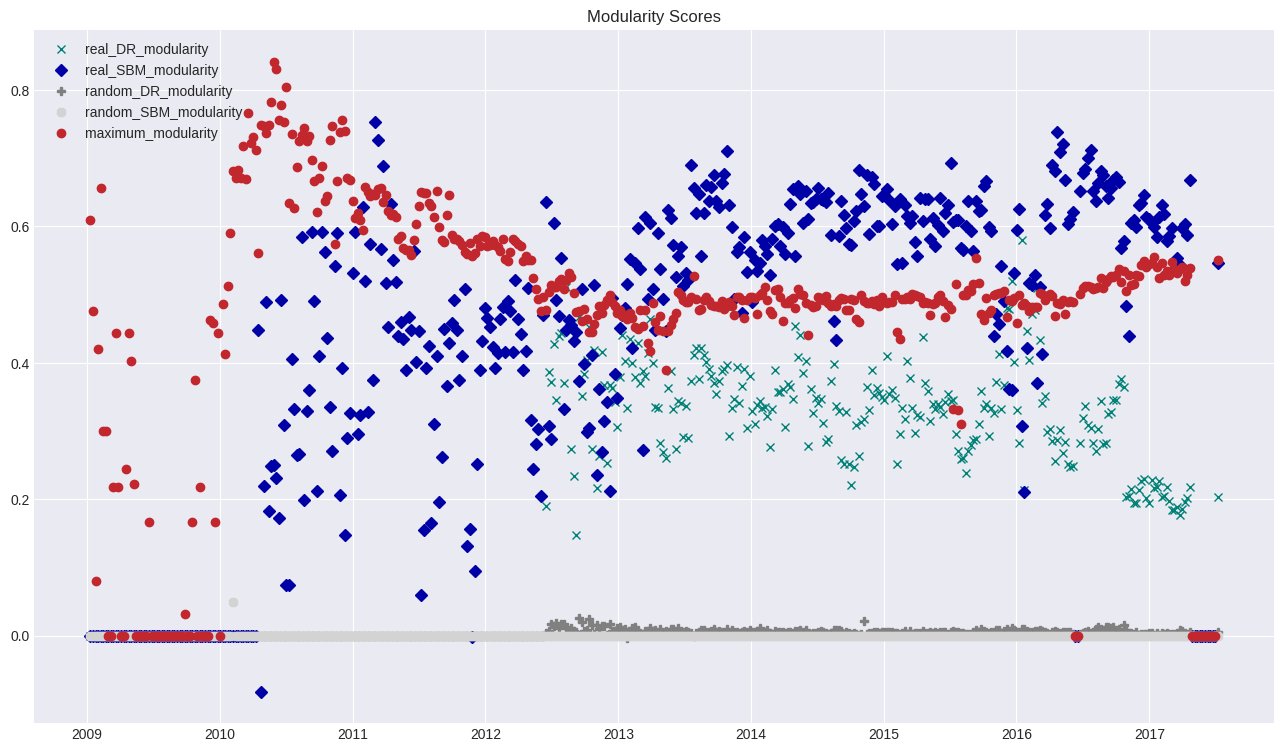

In [8]:
def daterange(date1, date2, by=1):
    return [  date1 + timedelta(n) for n in range(0, int((date2 - date1).days)+1, by) ]  

start_date = datetime.strptime("2009-01-10", "%Y-%m-%d").date()
end_date = datetime.strptime("2017-07-08", "%Y-%m-%d").date()
print(f'start_date is set as: {start_date}')
print(f'end_date is set as: {end_date}')

datelist = daterange(start_date, end_date, by=7)
tqdm_bar = tqdm(datelist, desc="processed files")

x_values = datelist
data_dicts = {
'real_DR': {},
'real_SBM': {},
'random_DR': {},
'random_SBM': {},
'maximum_modularity': {},
'clustering': {},
'clustering_std': {}}

# Load the data from the saved JSON files
data = {}
for key in data_dicts.keys():
    file_path = os.path.join(f'jsonResults_v3/h1/community', f'{key}_2009-01-03_{end_date}.json')
    with open(file_path, 'r') as f:
        data[key] = json.load(f)

dates = mdates.date2num(x_values)
fig = plt.figure(figsize=(16, 9), dpi=100)
plt.style.use('seaborn-darkgrid')

# Plot the data from the loaded JSON files
plt.plot_date(dates, list(data["real_DR"].values()), 'kx', linewidth=2, color='#008176', label="real_DR_modularity")
plt.plot_date(dates, list(data["real_SBM"].values()), 'kD', linewidth=2, color='#0000a7', label="real_SBM_modularity")
plt.plot_date(dates, list(data["random_DR"].values()), 'kP', linewidth=2, color='gray', label="random_DR_modularity")
plt.plot_date(dates, list(data["random_SBM"].values()), 'k8', linewidth=2, color='lightgray', label="random_SBM_modularity")
plt.plot_date(dates, list(data["maximum_modularity"].values()), 'ko', linewidth=2, color='#c1272d', label="maximum_modularity")
plt.legend(loc="upper left")
plt.gca().set_title("Modularity Scores")
plt.savefig(f'finalPlots/Modularity_Plot_full_final.png', dpi=120)


In [15]:
import json
import numpy as np
from scipy import stats
from datetime import datetime
import os

# Function to load data from a JSON file
def load_data(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

# Function to summarize data
def summarize_data(data, start_date):
    filtered_data = {k: v for k, v in data.items() if datetime.strptime(k, "%Y-%m-%d").date() > start_date}
    values = np.array(list(filtered_data.values()))

    # Remove NaN values
    values = values[~np.isnan(values)]
    
    mean_value = np.mean(values)
    median_value = np.median(values)
    std_value = np.std(values)
    min_value = np.min(values)
    max_value = np.max(values)
    skewness = stats.skew(values)
    kurtosis = stats.kurtosis(values)
    
    return {
        "Mean": mean_value,
        "Median": median_value,
        "Std Dev": std_value,
        "Min": min_value,
        "Max": max_value,
        "Skewness": skewness,
        "Kurtosis": kurtosis
    }

# Your specific end_date and start_date variables
end_date = datetime.strptime("2017-07-08", "%Y-%m-%d").date()
start_date = datetime.strptime("2011-05-08", "%Y-%m-%d").date()  # The day after 2011-05-07

# Your data dictionary keys
data_dicts = {
    'real_DR': {},
    'real_SBM': {},
    'random_DR': {},
    'random_SBM': {},
    'maximum_modularity': {},
}

# Load the data from the saved JSON files
data = {}
for key in data_dicts.keys():
    file_path = os.path.join(f'jsonResults_v3/h1/community', f'{key}_2009-01-03_{end_date}.json')
    data[key] = load_data(file_path)

# Loop over each data key to summarize the data
for key in data.keys():
    summary = summarize_data(data[key], start_date)
    print(f"Summary for {key}:")
    for k, value in summary.items():
        print(f"{k}: {value}")
    print()


Summary for real_DR:
Mean: 0.2599341193725243
Median: 0.31127461770820253
Std Dev: 0.15075555122939807
Min: -1.1841512025398842e-14
Max: 0.5802996807347319
Skewness: -0.7479912312246699
Kurtosis: -0.6756121915033351

Summary for real_SBM:
Mean: 0.5117705722583029
Median: 0.5668851261922583
Std Dev: 0.162564841591515
Min: -0.0022435542288365765
Max: 0.7387582286510183
Skewness: -1.551926700289527
Kurtosis: 2.1998069194743692

Summary for random_DR:
Mean: 0.005129168938331361
Median: 0.004882594554948331
Std Dev: 0.004457245902858447
Min: -0.0028488762765690443
Max: 0.026683323573468948
Skewness: 1.3166071338257408
Kurtosis: 3.0590390893876584

Summary for random_SBM:
Mean: -1.7108134703768376e-09
Median: 0.0
Std Dev: 3.065203494757939e-08
Min: -5.508871659274221e-07
Max: 1.9056974179517143e-12
Skewness: -17.86065830948159
Kurtosis: 317.00311525366993

Summary for maximum_modularity:
Mean: 0.48833605497714383
Median: 0.49586183446484833
Std Dev: 0.1061476068986861
Min: 0.0
Max: 0.6523851

# Gini, Entropy, Percentiles for h1 and random version / community vs vertex

start_date is set as: 2009-01-03
end_date is set as: 2017-07-08


processed files:   0%|          | 0/445 [4:54:16<?, ?it/s]
No handles with labels found to put in legend.
/tmp/ipykernel_2784624/3702831218.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, list(data["block_current_assets_gini"].values()), 'kx', linewidth=4, color='#c1272d', label="block_current_assets_gini", markersize=5)
/tmp/ipykernel_2784624/3702831218.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kD" (-> color='k'). The keyword argument will take precedence.
  plt.plot_date(dates, list(data["block_dark_assets_gini"].values()), 'kD', linewidth=4, color='#0000a7', label="block_dark_assets_gini", markersize=5)
/tmp/ipykernel_2784624/3702831218.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kP" (-> color='k'). The keyword argument will take pr

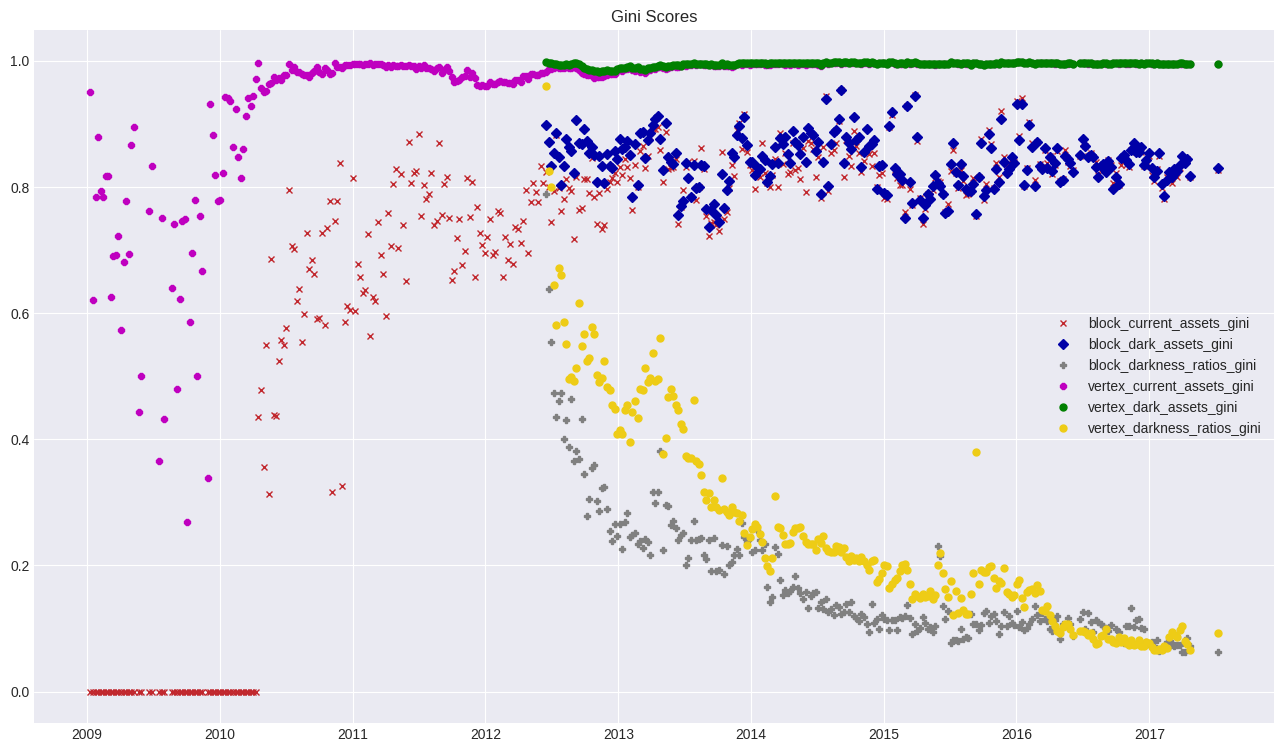

In [22]:
def daterange(date1, date2, by=1):
    return [  date1 + timedelta(n) for n in range(0, int((date2 - date1).days)+1, by) ]  

start_date = datetime.strptime("2009-01-03", "%Y-%m-%d").date()
end_date = datetime.strptime("2017-07-08", "%Y-%m-%d").date()
print(f'start_date is set as: {start_date}')
print(f'end_date is set as: {end_date}')

datelist = daterange(start_date, end_date, by=7)
tqdm_bar = tqdm(datelist, desc="processed files")

x_values = datelist
data_dicts = {
'block_current_assets_gini': {},
'block_dark_assets_gini': {},
'block_darkness_ratios_gini': {},
'vertex_current_assets_gini': {},
'vertex_dark_assets_gini': {},
'vertex_darkness_ratios_gini': {},
}

# Load the data from the saved JSON files
data = {}
for key in data_dicts.keys():
    file_path = os.path.join(f'jsonResults_v3/h1/community_inequality', f'{key}_2009-01-03_{end_date}.json')
    with open(file_path, 'r') as f:
        data[key] = json.load(f)

# Generate dates from keys in JSON files, convert them to datetime object
x_values = [datetime.strptime(date, "%Y-%m-%d").date() for date in data['block_current_assets_gini'].keys()]
dates = mdates.date2num(x_values)

fig = plt.figure(figsize=(16, 9), dpi=100)
plt.style.use('seaborn-darkgrid')
plt.legend(loc="upper left")
# Plot the data from the loaded JSON files
plt.plot_date(dates, list(data["block_current_assets_gini"].values()), 'kx', linewidth=4, color='#c1272d', label="block_current_assets_gini", markersize=5)
plt.plot_date(dates, list(data["block_dark_assets_gini"].values()), 'kD', linewidth=4, color='#0000a7', label="block_dark_assets_gini", markersize=5)
plt.plot_date(dates, list(data["block_darkness_ratios_gini"].values()), 'kP', linewidth=4, color='gray', label="block_darkness_ratios_gini", markersize=5)
plt.plot_date(dates, list(data["vertex_current_assets_gini"].values()), 'k8', linewidth=4, color='m', label="vertex_current_assets_gini", markersize=5)
plt.plot_date(dates, list(data["vertex_dark_assets_gini"].values()), 'ko', linewidth=4, color='green', label="vertex_dark_assets_gini", markersize=5)
plt.plot_date(dates, list(data["vertex_darkness_ratios_gini"].values()), 'ko', linewidth=4, color='#eecc16', label="vertex_darkness_ratios_gini", markersize=5)
plt.legend()
plt.gca().set_title("Gini Scores")
plt.savefig(f'finalPlots/Gini_Plot_full.png', dpi=100)


In [26]:
# Your specific end_date and heuristic variables
end_date = datetime.strptime("2017-07-08", "%Y-%m-%d").date()

# Your data dictionary keys
data_dicts = {
'block_current_assets_gini': {},
'block_dark_assets_gini': {},
'block_darkness_ratios_gini': {},
'vertex_current_assets_gini': {},
'vertex_dark_assets_gini': {},
'vertex_darkness_ratios_gini': {},
}

# Load the data from the saved JSON files
data = {}
for key in data_dicts.keys():
    file_path = os.path.join(f'jsonResults_v3/h1/community_inequality', f'{key}_2009-01-03_{end_date}.json')
    data[key] = load_data(file_path)

# Loop over each data key to summarize the data
for key in data.keys():
    summary = summarize_data(data[key])
    print(f"Summary for {key}:")
    for k, value in summary.items():
        print(f"{k}: {value}")
    print()

Summary for block_current_assets_gini:
Mean: 0.6774383287406738
Median: 0.7994310382073093
Std Dev: 0.284264786598447
Min: 0.0
Max: 0.9540897697746504
Skewness: -1.7599267338515279
Kurtosis: 1.5123481333905575

Summary for block_dark_assets_gini:
Mean: 0.840242524383293
Median: 0.8386801160452774
Std Dev: 0.03954050891690236
Min: 0.7361950621967291
Max: 0.9540696141047315
Skewness: -0.014119914255611227
Kurtosis: 0.0570101171560391

Summary for block_darkness_ratios_gini:
Mean: 0.17489066274191478
Median: 0.12698610258446574
Std Dev: 0.10565028768756955
Min: 0.06293653441844604
Max: 0.7890123577931498
Skewness: 1.982530750241293
Kurtosis: 5.743786158685101

Summary for vertex_current_assets_gini:
Mean: 0.9555939336719645
Median: 0.9925117533068639
Std Dev: 0.1047901948070839
Min: 0.2692307692307692
Max: 0.998537676142497
Skewness: -3.702848425799272
Kurtosis: 14.792941974073944

Summary for vertex_dark_assets_gini:
Mean: 0.9945833566446216
Median: 0.9956020577566735
Std Dev: 0.00318044

# Percentiles 

start_date is set as: 2009-01-03
end_date is set as: 2017-07-08


processed files:   0%|          | 0/445 [00:06<?, ?it/s]
/tmp/ipykernel_3471571/1195139094.py:75: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[plot_index].plot_date(dates, list(data[f"{key}_{percentile}"].values()), marker='o', linewidth=2,
/tmp/ipykernel_3471571/1195139094.py:75: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[plot_index].plot_date(dates, list(data[f"{key}_{percentile}"].values()), marker='o', linewidth=2,
/tmp/ipykernel_3471571/1195139094.py:75: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[plot_index].plot_date(dates, list(data[f"{key}_{percentile}"].values()), marker='o', linewidth=2,
/tmp/ipykernel_3471571/11951

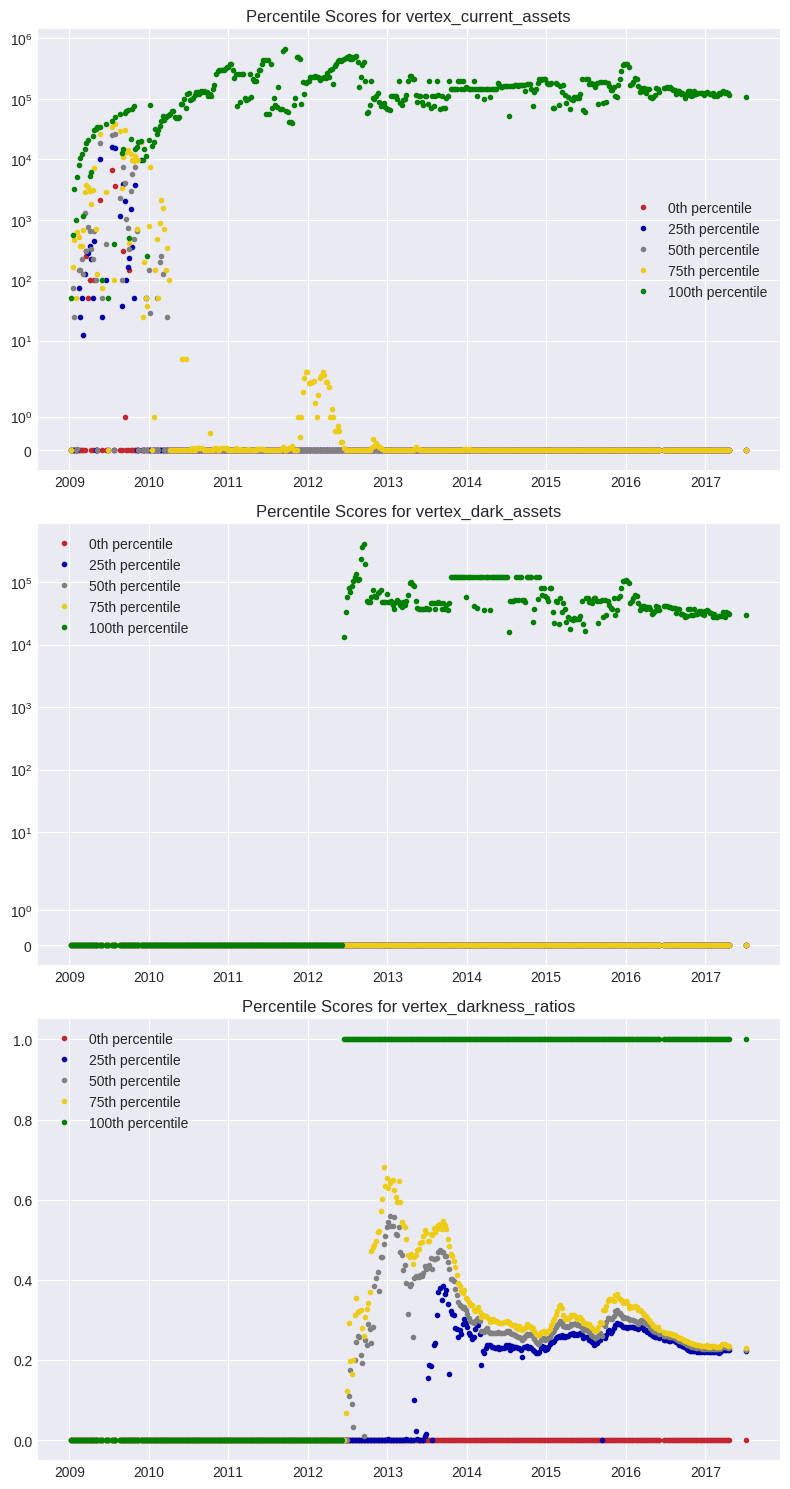

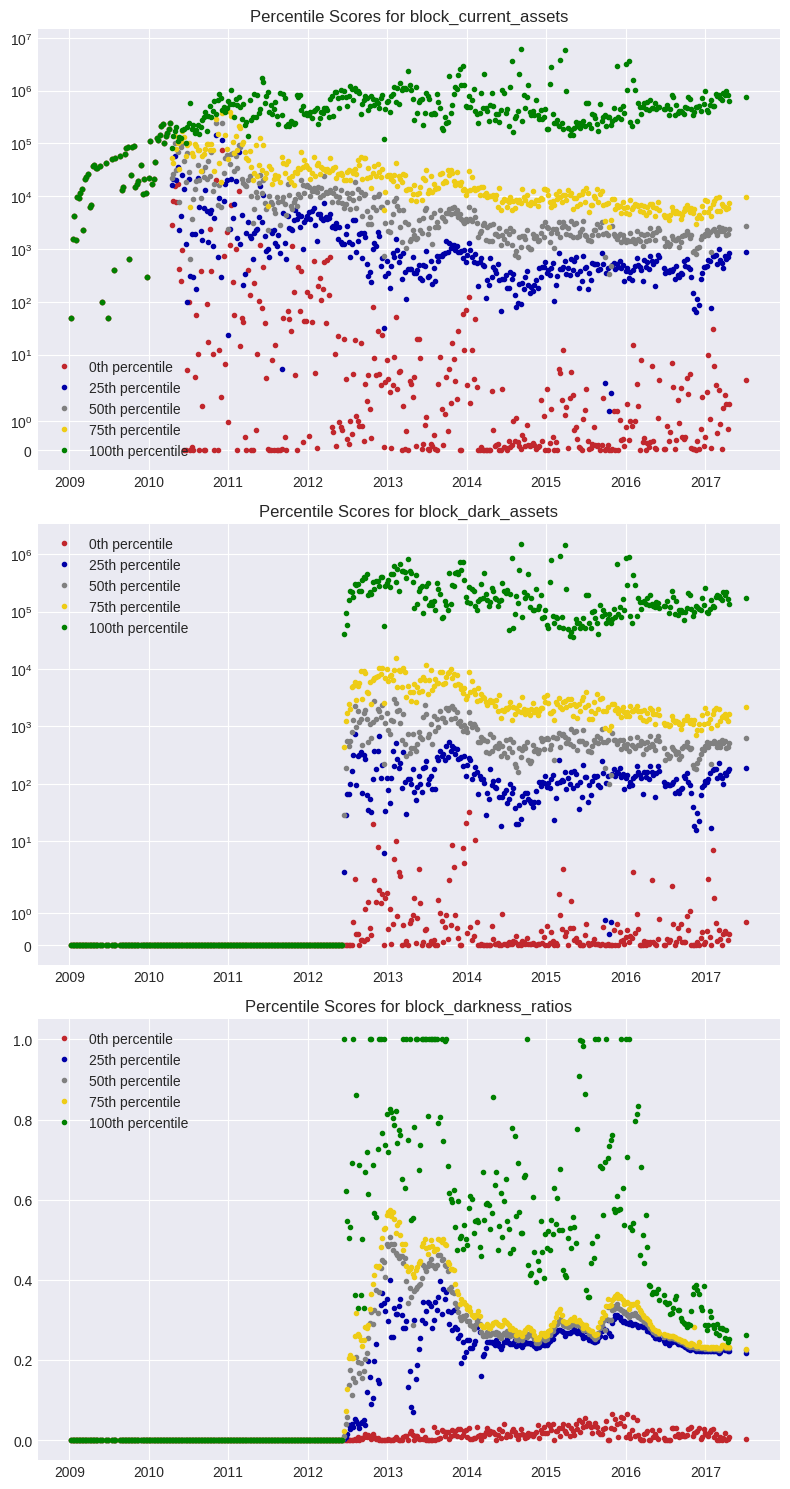

In [23]:
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

def daterange(date1, date2, by=1):
    return [date1 + timedelta(n) for n in range(0, int((date2 - date1).days) + 1, by)]

start_date = datetime.strptime("2009-01-03", "%Y-%m-%d").date()
end_date = datetime.strptime("2017-07-08", "%Y-%m-%d").date()
print(f'start_date is set as: {start_date}')
print(f'end_date is set as: {end_date}')

datelist = daterange(start_date, end_date, by=7)
tqdm_bar = tqdm(datelist, desc="processed files")

percentiles = [0, 25, 50, 75, 100]
data_dicts = {
    'block_current_assets': {},
    'block_dark_assets': {},
    'block_darkness_ratios': {},
    'vertex_current_assets': {},
    'vertex_dark_assets': {},
    'vertex_darkness_ratios': {},
}

# Load the data from the saved JSON files
data = {}
for key in data_dicts.keys():
    for percentile in percentiles:
        file_path = os.path.join(f'jsonResults_v3/h1/community_inequality', f'{key}_{percentile}th_percentile_2009-01-03_{end_date}.json')
        with open(file_path, 'r') as f:
            data_values = json.load(f)

            # If assets, convert from Satoshi to Bitcoin
            if 'assets' in key:
                data_values = {k: v / 100000000 for k, v in data_values.items()}

            data[f"{key}_{percentile}"] = data_values

# Generate dates from keys in JSON files, convert them to datetime object
x_values = [datetime.strptime(date, "%Y-%m-%d").date() for date in data[f'{list(data_dicts.keys())[0]}_{0}'].keys()]
dates = mdates.date2num(x_values)

colors = ['#c1272d', '#0000a7', 'gray', '#eecc16', 'green', 'yellow']

# Ensure directory exists
os.makedirs('finalPlots/percentilePlots', exist_ok=True)

# Create two figures, one for vertex plots and one for block plots
num_vertex_plots = sum('vertex' in key for key in data_dicts.keys())
num_block_plots = sum('block' in key for key in data_dicts.keys())

fig_vertex, axes_vertex = plt.subplots(num_vertex_plots, 1, figsize=(8, 5*num_vertex_plots), dpi=100)
fig_block, axes_block = plt.subplots(num_block_plots, 1, figsize=(8, 5*num_block_plots), dpi=100)

# Plot the data from the loaded JSON files
vertex_plot_index = 0
block_plot_index = 0

for idx, key in enumerate(data_dicts.keys()):
    if 'vertex' in key:
        axes = axes_vertex
        fig = fig_vertex
        plot_index = vertex_plot_index
        vertex_plot_index += 1
    else:
        axes = axes_block
        fig = fig_block
        plot_index = block_plot_index
        block_plot_index += 1

    for percentile in percentiles:
        axes[plot_index].plot_date(dates, list(data[f"{key}_{percentile}"].values()), marker='o', linewidth=2,
                            color=colors[percentile // 25], label=f"{percentile}th percentile", markersize=3)

    if 'assets' in key:
        axes[plot_index].set_yscale('symlog')  # set yscale to symlog if 'assets' is in the key

    axes[plot_index].legend()
    axes[plot_index].set_title(f"Percentile Scores for {key}")

fig_vertex.tight_layout()
fig_vertex.savefig(f'finalPlots/percentilePlots/Vertex_Plots.png', dpi=100)

fig_block.tight_layout()
fig_block.savefig(f'finalPlots/percentilePlots/Block_Plots.png', dpi=100)

In [21]:
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

def daterange(date1, date2, by=1):
    return [date1 + timedelta(n) for n in range(0, int((date2 - date1).days) + 1, by)]

start_date = datetime.strptime("2009-01-03", "%Y-%m-%d").date()
end_date = datetime.strptime("2017-07-08", "%Y-%m-%d").date()
print(f'start_date is set as: {start_date}')
print(f'end_date is set as: {end_date}')

datelist = daterange(start_date, end_date, by=7)
tqdm_bar = tqdm(datelist, desc="processed files")

percentiles = [0, 25, 50, 75, 100]
data_dicts = {
    'block_current_assets': {},
    'block_dark_assets': {},
    'block_darkness_ratios': {},
    'vertex_current_assets': {},
    'vertex_dark_assets': {},
    'vertex_darkness_ratios': {},
}

# Load the data from the saved JSON files
data = {}
for key in data_dicts.keys():
    for percentile in percentiles:
        file_path = os.path.join(f'jsonResults_v3/h1/community_inequality', f'{key}_{percentile}th_percentile_2009-01-03_{end_date}.json')
        with open(file_path, 'r') as f:
            data_values = json.load(f)

            # If assets, convert from Satoshi to Bitcoin
            if 'assets' in key:
                data_values = {k: v / 100000000 for k, v in data_values.items()}

            data[f"{key}_{percentile}"] = data_values

# Generate dates from keys in JSON files, convert them to datetime object
x_values = [datetime.strptime(date, "%Y-%m-%d").date() for date in data[f'{list(data_dicts.keys())[0]}_{0}'].keys()]
dates = mdates.date2num(x_values)

colors = ['#c1272d', '#0000a7', 'gray', '#eecc16', 'green', 'yellow']

# Ensure directory exists
os.makedirs('finalPlots/percentilePlots', exist_ok=True)

# Create a single figure with 2 columns, one for vertex plots and one for block plots
num_plots = len(data_dicts.keys())
fig, axes = plt.subplots(num_plots, 2, figsize=(16, 5 * num_plots), dpi=400)

vertex_plot_index = 0
block_plot_index = 0

for idx, key in enumerate(data_dicts.keys()):
    if 'vertex' in key:
        axes_current = axes[vertex_plot_index, 1]
        vertex_plot_index += 1
    else:
        axes_current = axes[block_plot_index, 0]
        block_plot_index += 1

    for percentile in percentiles:
        axes_current.plot_date(dates, list(data[f"{key}_{percentile}"].values()), marker='o', linewidth=2,
                            color=colors[percentile // 25], label=f"{percentile}th percentile", markersize=3)

    if 'assets' in key:
        axes_current.set_yscale('symlog')

    axes_current.legend()
    axes_current.set_title(f"Percentile Scores for {key}")

fig.tight_layout()
fig.savefig(f'finalPlots/percentilePlots/Combined_Plots.png', dpi=100)


start_date is set as: 2009-01-03
end_date is set as: 2017-07-08


processed files:   0%|          | 0/445 [00:30<?, ?it/s]
/tmp/ipykernel_2784624/2874870555.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes_current.plot_date(dates, list(data[f"{key}_{percentile}"].values()), marker='o', linewidth=2,
/tmp/ipykernel_2784624/2874870555.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes_current.plot_date(dates, list(data[f"{key}_{percentile}"].values()), marker='o', linewidth=2,
/tmp/ipykernel_2784624/2874870555.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes_current.plot_date(dates, list(data[f"{key}_{percentile}"].values()), marker='o', linewidth=2,
/tmp/ipykernel_2784624/2874870555.py:67: